# Question 1: Predicting pitch being put in Play

In [1]:
# Import libraries needed
import pandas as pd
from lightgbm.sklearn import LGBMClassifier
from scipy.stats import lognorm, loguniform, randint
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import altair as alt
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

### Initial exploration

In [2]:
# Reading the data and displaying the first few rows
train_df = pd.read_csv('data/training.csv')
train_df.head(3)

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39


In [3]:
# Glimpse of column types and null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            10000 non-null  int64  
 1   Velo              10000 non-null  float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         10000 non-null  float64
 4   InducedVertBreak  10000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


**There are six records in the dataset where the Spin Rate of the pitch at release (in rpm) contains null values. These rows will be removed from the dataset as they account for a mere 0.06% of the total number of rows.**

In [4]:
# Drop null values
train_df = train_df.dropna(axis=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            9994 non-null   int64  
 1   Velo              9994 non-null   float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         9994 non-null   float64
 4   InducedVertBreak  9994 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 468.5 KB


### Exploratory Data Analysis

In [5]:
# Quick summary statistics
train_df.describe()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,0.271763,93.957601,2238.952471,9.547185,14.175964
std,0.444891,2.684281,196.041323,5.052148,4.604653
min,0.000000,59.760000,770.000000,-6.270000,-6.820000
25%,0.000000,92.540000,2107.000000,5.730000,11.370000
50%,0.000000,94.100000,2241.000000,9.430000,15.160000
75%,1.000000,95.660000,2367.000000,13.600000,17.630000
max,1.000000,102.040000,3061.000000,28.040000,24.860000


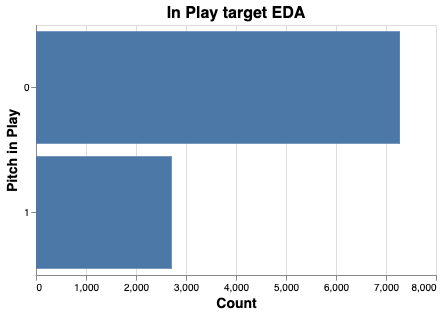

In [6]:
# Plotting InPlay Target Column
inplay_plot = alt.Chart(train_df).mark_bar().encode(
    x=alt.X('count()', title='Count'),
    y=alt.Y('InPlay:N', title='Pitch in Play')
    ).properties(
    title='In Play target EDA',height=250, width=400).configure_axis(
    titleFontSize=14
    ).configure_title(
    fontSize=16
    )
inplay_plot

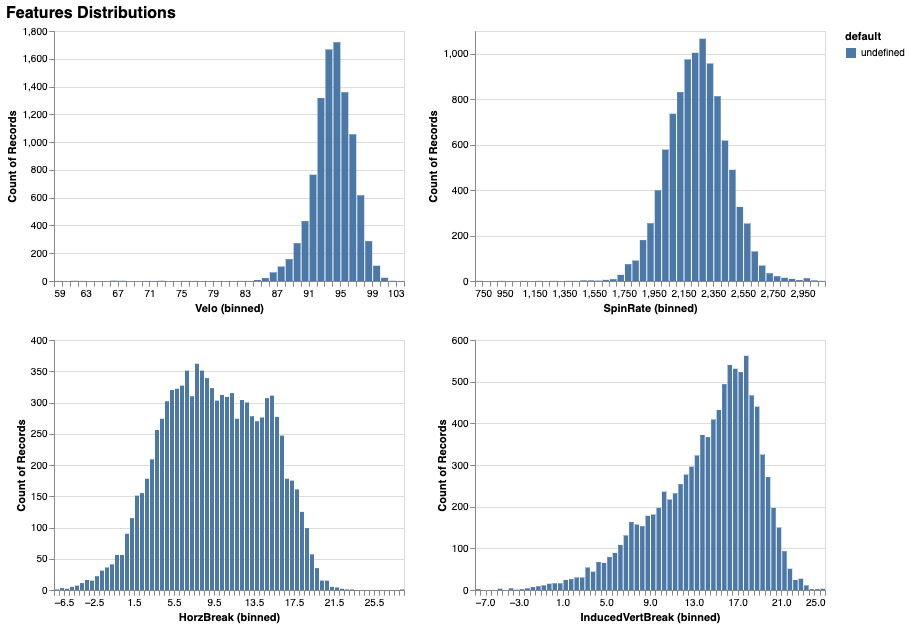

In [7]:
# Feature distributions plots
num_titles = (
    train_df.drop(columns=["InPlay"])
    .columns.to_list()
)

alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=70)),
    y="count()",
    color="default:N",
).properties(width=350, height=250).repeat(
    num_titles, columns=2
).properties(
    title="Features Distributions"
).configure_title(
    fontSize=16
)

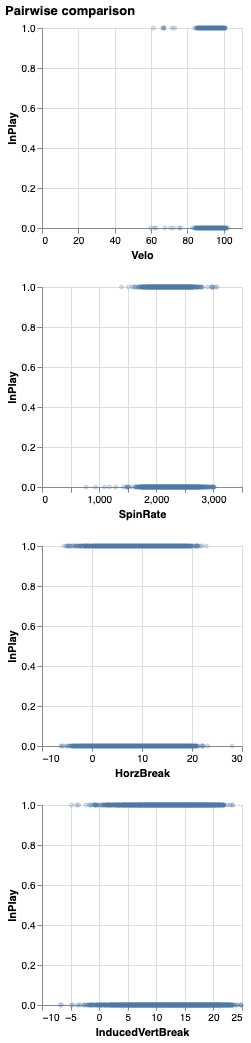

In [8]:
# Correlation plots
pair_chart = alt.Chart(train_df).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative')
).properties(
    width=200,
    height=200
).repeat(
    column=['InPlay'],
    row=['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']
).properties(
    title="Pairwise comparison"
    )
pair_chart

**Initial Observations Summary:**

**Our classification problem exhibits a class imbalance, therefore, f1 is a proper metric to assess model performance. in addition, upon initial inspection, there appear to be no variables displaying a notably strong correlation with the target variable.**

### Transformations

In [9]:
# Creating X_train, y_train
X_train = train_df.drop(columns="InPlay")
y_train = train_df["InPlay"]

# Building pipeline
preprocessor = make_column_transformer(
    (StandardScaler(), num_titles)
)

### Modeling

#### Baseline Model

In [10]:
# Training dummy classifier as baseline

dc = DummyClassifier()
cross_val_results = {}
cross_val_results["Dummy"] = (
    pd.DataFrame(
        cross_validate(
            dc,
            X_train,
            y_train,
            return_train_score=True,
            scoring="f1"
        )
    )
    .agg(["mean", "std"])
    .round(3)
    .T
)

# Show the train and validation scores
cross_val_results["Dummy"]

,mean,std
fit_time,0.000,0.0
score_time,0.001,0.0
test_score,0.000,0.0
train_score,0.000,0.0


#### Linear models

In [11]:
# Training logistic regression

pipe_logreg = make_pipeline(
    preprocessor, LogisticRegression(random_state=123, class_weight="balanced")
)

cross_val_results["LogReg"] = (
    pd.DataFrame(
        cross_validate(
            pipe_logreg,
            X_train,
            y_train,
            return_train_score=True,
            scoring="f1"
        )
    )
    .agg(["mean", "std"])
    .round(3)
    .T
)

# Show the train and validation scores
cross_val_results["LogReg"]

,mean,std
fit_time,0.009,0.002
score_time,0.002,0.000
test_score,0.385,0.029
train_score,0.387,0.005


#### Non-Linear models

In [12]:
# Training Gaussian Naive Bayes

NB_bal = make_pipeline(preprocessor, GaussianNB())

cross_val_results["NB"] = (
    pd.DataFrame(
        cross_validate(
            NB_bal,
            X_train,
            y_train,
            return_train_score=True,
            scoring="f1"
        )
    )
    .agg(["mean", "std"])
    .round(3)
    .T
)
# Show the train and validation scores
cross_val_results["NB"]

,mean,std
fit_time,0.002,0.000
score_time,0.001,0.000
test_score,0.074,0.017
train_score,0.078,0.026


In [13]:
# Training tree based model, Light Gradient Boosting Machine

LGBM_bal = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123, class_weight="balanced")
)

cross_val_results["LGBM"] = (
    pd.DataFrame(
        cross_validate(
            LGBM_bal,
            X_train,
            y_train,
            return_train_score=True,
            scoring="f1"
        )
    )
    .agg(["mean", "std"])
    .round(3)
    .T
)
# Show the train and validation scores
cross_val_results["LGBM"]

,mean,std
fit_time,0.266,0.034
score_time,0.004,0.000
test_score,0.349,0.014
train_score,0.681,0.003


In [14]:
# Showing all results

combined_results = (
    pd.concat(cross_val_results, axis="columns")
    .xs("mean", axis="columns", level=1)
    .style.format(precision=3)
)

combined_results

,Dummy,LogReg,NB,LGBM
fit_time,0.000,0.009,0.002,0.266
score_time,0.001,0.002,0.001,0.004
test_score,0.000,0.385,0.074,0.349
train_score,0.000,0.387,0.078,0.681


### Hyperparameter optimization and model selection

In [15]:
# Logistic regression hyperparameter optimization

param_dist_logreg = {
    "logisticregression__C": loguniform(1e-3, 1e3),
}

random_search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_dist_logreg,
    n_jobs=-1,
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring="f1"
)
random_search_logreg.fit(X_train, y_train)

cross_val_results["LogReg_Opt"] = (
    pd.DataFrame(
        cross_validate(
            random_search_logreg.best_estimator_,
            X_train,
            y_train,
            return_train_score=True,
            scoring="f1"
        )
    )
    .agg(["mean", "std"])
    .round(3)
    .T
)

# Show the train and validation scores
cross_val_results["LogReg_Opt"]

,mean,std
fit_time,0.005,0.000
score_time,0.001,0.000
test_score,0.386,0.027
train_score,0.388,0.005


In [16]:
# Light Gradient Boosting Machine hyperparameter optimization

param_dist_lgbm = {
    "lgbmclassifier__learning_rate": [0.001, 0.01, 0.05, 0.07, 0.1],
    "lgbmclassifier__n_estimators": randint(0, 100),
    "lgbmclassifier__max_depth": randint(0, 20),
    "lgbmclassifier__num_leaves": [10, 25, 50, 100],
}

random_search_LGBM = RandomizedSearchCV(
    LGBM_bal,
    param_distributions=param_dist_lgbm,
    n_jobs=-1,
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring="f1"
)

random_search_LGBM.fit(X_train, y_train)

cross_val_results["LGBM_Opt"] = (
    pd.DataFrame(
        cross_validate(
            random_search_LGBM.best_estimator_,
            X_train,
            y_train,
            return_train_score=True,
            scoring="f1"
        )
    )
    .agg(["mean", "std"])
    .round(3)
    .T
)

# Show the train and validation scores
cross_val_results["LGBM_Opt"]

,mean,std
fit_time,0.035,0.003
score_time,0.002,0.000
test_score,0.398,0.024
train_score,0.441,0.006


In [17]:
# Displaying results

combined_results = (
    pd.concat(cross_val_results, axis="columns")
    .xs("mean", axis="columns", level=1)
    .style.format(precision=3)
)

combined_results

,Dummy,LogReg,NB,LGBM,LogReg_Opt,LGBM_Opt
fit_time,0.000,0.009,0.002,0.266,0.005,0.035
score_time,0.001,0.002,0.001,0.004,0.001,0.002
test_score,0.000,0.385,0.074,0.349,0.386,0.398
train_score,0.000,0.387,0.078,0.681,0.388,0.441


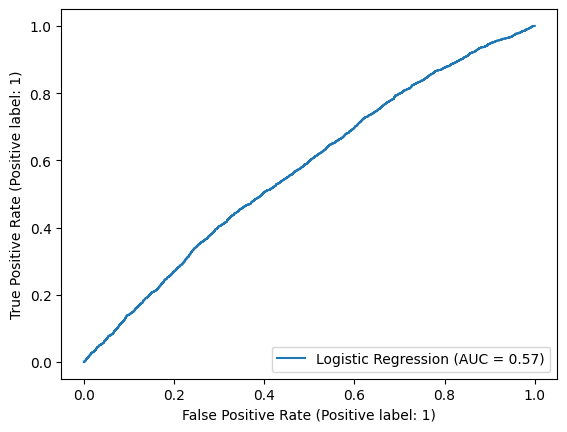

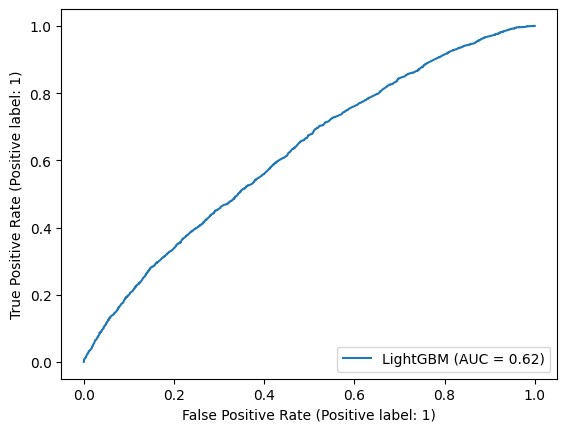

In [18]:
# Displaying AUC for model selection

RocCurveDisplay.from_estimator(
    random_search_logreg.best_estimator_, X_train, y_train, name="Logistic Regression"
)

RocCurveDisplay.from_estimator(
    random_search_LGBM.best_estimator_, X_train, y_train, name="LightGBM"
)

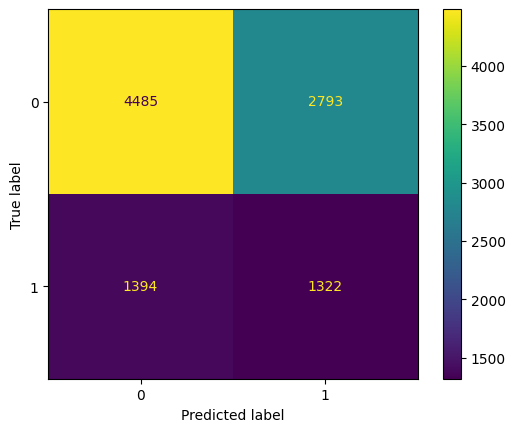

In [39]:
# LightGBM confusion matrix

ConfusionMatrixDisplay.from_estimator(random_search_logreg.best_estimator_, X_train, y_train)

### Predicting using deploy data

In [42]:
test_df = pd.read_csv('data/deploy.csv')
# Drop null values
test_df = test_df.dropna(axis=0)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9987 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Velo              9987 non-null   float64
 1   SpinRate          9987 non-null   float64
 2   HorzBreak         9987 non-null   float64
 3   InducedVertBreak  9987 non-null   float64
dtypes: float64(4)
memory usage: 390.1 KB


In [50]:
# Saving best estimator
best_estimator = random_search_logreg.best_estimator_

# Make predictions on deploy data data
y_pred = best_estimator.predict(test_df)


In [48]:
results_df = test_df.copy()
results_df['predicted_InPlay'] = y_pred  

# Save the results to a CSV file
results_df.to_csv('results.csv', index=False) 

In [49]:
results_df.head(3)

,Velo,SpinRate,HorzBreak,InducedVertBreak,predicted_InPlay
0,94.72,2375.0,3.10,18.15,0
1,95.25,2033.0,11.26,14.50,1
2,92.61,2389.0,11.00,21.93,0


# Question 2: Reasoning for Q1

The solution process began with an exploratory analysis to identify the proportion of positive labels and selecting the appropriate metric to train the models, in addition to having a glimpse of the features' distributions and their correlations with the target variable. Subsequently, I standardized the features to mitigate the impact of varying magnitudes before proceeding with the training of both linear and non-linear models. Upon reviewing the results table from the modeling phase, it became apparent that both logistic regression and the light gradient boosting classifier exhibited similar performance. However, there was a concern about overfitting in the case of the light gradient boosting classifier (LGBM). To address this issue, I conducted hyperparameter optimization. Following this optimization and the plotting of precision-recall curves, it was evident that the LGBM's performance improved. Given the importance of interpretability in our problem, I ultimately chose the logistic regression model as the best option. It's worth noting that while tools like SHAP (SHapley Additive exPlanations) can aid in interpreting non-linear models, the coefficients of linear models offer a straightforward and direct interpretation, aligning with the interpretability requirement of Q3.


# Question 3: How variables affect the batter’s ability to put the ball in play


In [64]:
logreg_model = best_estimator.named_steps['logisticregression'] 
coefficients = logreg_model.coef_
coefficients

array([[-0.074204  , -0.04858006,  0.07028731, -0.1226105 ]])

In [65]:
coef_dict = {}
for feature, coef in zip(num_titles, coefficients[0]):
    coef_dict[feature] = coef

for feature, coef in coef_dict.items():
    print(f"{feature}: {coef}")
    


Velo: -0.0742040006485658
SpinRate: -0.04858005546348437
HorzBreak: 0.07028731178883518
InducedVertBreak: -0.12261050498276177


Considering that all variables are independent. 

If the amount of movement the pitch had in the horizontal direction increases, there is a higher probability of the batter putting the ball in play. Whereas an increase in either the velocity of the pitch release, the spin rate or the amount of movement the pitch had in the vertical direction causes a lower probability of the batter putting the ball in play. 

# Question 4: Next steps 

I would love to spend more time in experimenting with non-linear models and fine-tuning their performance, with the aim of identifying a superior performer in contrast to Logistic Regression, since the feature in real life are not independent, and also trying to incorporate more data sources (for example context-dependent data). Furthermore, I would explore model interpretability techniques to provide actionable insights for the pitcher and the coaching staff, helping them optimize their pitching strategy based on these factors.